### Data Preparation using vreat package

> Some issues `vtreat` helps with include the following:
    - Missing values in numeric variables 
    - Extreme or out-of-range values in numeric variables
    - Missing values in categorical variables
    - Novel values (values seen during testing or application, but not during training) in categorical data
    - Categorical data with very many possible values
    - Overfit due to a large number of variables
    - Overfit due to "nested model bias"
    
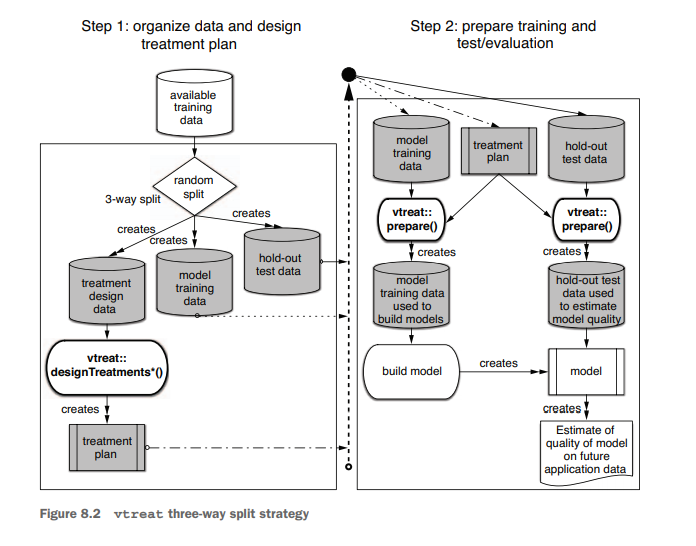

In [2]:
d <- read.table("PDSwR2/KDD2009/orange_small_train.data.gz",
               header=TRUE,
               sep='\t',
               na.strings = c('NA', ''))

In [3]:
#reads the known churn outcomes
churn <- read.table("PDSwR2/KDD2009/orange_small_train_churn.labels.txt",
                   header=FALSE, sep='\t')
d$churn <- churn$V1

set.seed(729375)
rgroup <- base::sample(c('train', 'calibrate', 'test'),
                      nrow(d),
                      prob=c(0.8, 0.1, 0.1),
                      replace=TRUE)
dTrain <- d[rgroup == 'train', , drop = FALSE]
dCal <- d[rgroup == 'calibrate', , drop = FALSE]
dTrainAll <- d[rgroup %in% c('train', 'calibrate'), , drop = FALSE]
dTest <- d[rgroup == 'test', , drop=FALSE]

outcome <- 'churn'
vars <- setdiff(colnames(dTrainAll), outcome)

In [4]:
# removes unneeded objects from the workspace
rm(list=c('d', 'churn', 'rgroup'))

In [5]:
str(dTrain)

'data.frame':	40053 obs. of  231 variables:
 $ Var1  : int  NA NA NA NA NA NA NA NA NA NA ...
 $ Var2  : int  NA NA NA NA NA NA NA NA NA NA ...
 $ Var3  : int  NA NA NA NA NA NA NA NA NA NA ...
 $ Var4  : int  NA NA NA NA NA NA NA NA NA NA ...
 $ Var5  : int  NA NA NA NA NA NA NA NA NA NA ...
 $ Var6  : int  1526 525 5236 NA 1029 658 77 1176 1141 490 ...
 $ Var7  : int  7 0 7 0 7 7 0 7 7 7 ...
 $ Var8  : logi  NA NA NA NA NA NA ...
 $ Var9  : int  NA NA NA NA NA NA NA NA NA NA ...
 $ Var10 : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Var11 : int  NA NA NA NA NA NA NA NA NA NA ...
 $ Var12 : int  NA NA NA NA NA NA NA NA NA NA ...
 $ Var13 : int  184 0 904 0 3216 3156 0 2912 164 2060 ...
 $ Var14 : int  NA NA NA NA NA NA NA NA NA NA ...
 $ Var15 : logi  NA NA NA NA NA NA ...
 $ Var16 : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Var17 : int  NA NA NA NA NA NA NA NA NA NA ...
 $ Var18 : int  NA NA NA NA NA NA NA NA NA NA ...
 $ Var19 : int  NA NA NA NA NA NA NA NA NA NA ...
 $ Var20 : logi  

In [9]:
#tabulates churn outcome
outcome_summary <- table(churn = dTrain[, outcome],
                        useNA = 'ifany') 

#create table
knitr::kable(outcome_summary) 



|churn |  Freq|
|:-----|-----:|
|-1    | 37110|
|1     |  2943|

In [10]:
outcome_summary["1"]/sum(outcome_summary)

1 
0.07347764

#### The bull-in-china-shop approach

as First attempt, use both the `dTrain` and `dCal` data togeteher to fit the model (as the set `dTrainAll`)
Lets see what happens if we jump in and immediately try to build a model for `churn`==1

In [11]:
library("wrapr")

Warning message:
"package 'wrapr' was built under R version 3.6.3"

In [12]:
outcome <- 'churn'
vars <- setdiff(colnames(dTrainAll), outcome)

#builds a model formula specification, asking churn==1 to be predicted as a function of explanatory variables
formula1 <- mk_formula("churn", vars, outcome_target=1)

#ask the glm() function to build a regression model
model1 <- glm(formula1, data=dTrainAll, family=binomial)

ERROR: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]): contrasts can be applied only to factors with 2 or more levels


> The execution was failed due to some of the columns to be used as explanatory variables do not vary and have exact same value for every row or example

#### Trying just one variable

In [13]:
model2 <- glm((churn == 1) ~ Var1, data=dTrainAll, family=binomial)
summary(model2)


Call:
glm(formula = (churn == 1) ~ Var1, family = binomial, data = dTrainAll)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.3685  -0.3685  -0.3685  -0.3661   2.3762  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.6556108  0.1684722 -15.763   <2e-16 ***
Var1        -0.0008306  0.0045203  -0.184    0.854    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 303.31  on 629  degrees of freedom
Residual deviance: 303.27  on 628  degrees of freedom
  (44395 observations deleted due to missingness)
AIC: 307.27

Number of Fisher Scoring iterations: 5


> What jumps out here is the line “44407 observations deleted due to missingness.” This means the modeling
procedures threw out 44407 of our 45028 training rows, building a model on the remaining 621 rows of data. So in addition to columns that do not vary, we have columns that have damaging amounts of missing values

In [14]:
head(dTrainAll$Var200)

[1] <NA>    <NA>    vynJTq9 <NA>    0v21jmy <NA>   
15415 Levels: _84etK_ _9bTOWp _A3VKFm _bq4Nkb _ct4nkXBMp _ctPxPXAwI ... zzQ9udm

> The `head()` command shows us the first few values of `Var200`, telling us this column
has string values encoded as factors. Factors are R’s representation for strings taken
from a known set. And this is where an additional problem lies. Notice the listing says
the factor has 15415 possible levels. A factor or string variable with this many distinct
levels is going to be a big problem in terms of overfitting and also difficult for the
`glm()` code to work with

In [15]:
length(unique(dTrainAll$Var200))

[1] 14418

> the `length(unique(dTrainAllVar200))` summary tells us that Var200 takes on only 14391 distinct values in our training sample. This tells us our training data sample did not see all known values for this variable.

Above problems can possibly be deal with `vtreat`

### Basic Data Preparation for classification

`vtreat` prepares data for use by both cleaning up existing columns or variables and by introducing new columns or variables.

First, a portion of the data (`dTrain` set) will be used to design variable treatments

In [22]:
library(vtreat)

# Starts up a parallel cluster to speed up calculation
(parallel_cluster <- parallel::makeCluster(parallel::detectCores()))

# Use designtreatmentsC() to learn the treatment plan for training data
treatment_plan <- vtreat::designTreatmentsC(
    dTrain,
    varlist = vars,
    outcomename = 'churn',
    outcometarget = 1,
    verbose = FALSE,
    parallelCluster = parallel_cluster)

socket cluster with 8 nodes on host 'localhost'

After `treatment_plsn` is created, the next step is to apply it to the traing data `dTrain`. The `prepare()` method builds a new data frame with the same row order as the original data frame, and columns from the treatment plan (plus copying over the dependent variable column if its present)

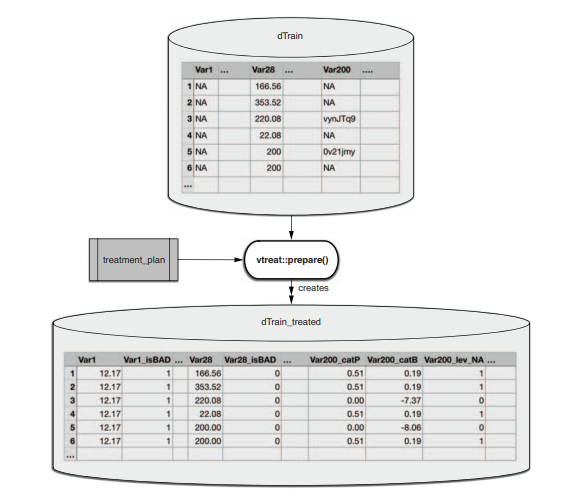

In [23]:
# Applying treatemnt_plan to dTrain
dTrain_treated <- prepare(treatment_plan,
                         dTrain,
                         parallelCluster = parallel_cluster)

# Compare the columns of original data with its treated counterpart
head(colnames(dTrain))
head(colnames(dTrain_treated))

Warning message in prepare.treatmentplan(treatment_plan, dTrain, parallelCluster = parallel_cluster):
"possibly called prepare() on same data frame as designTreatments*()/mkCrossFrame*Experiment(), this can lead to over-fit.  To avoid this, please use mkCrossFrame*Experiment$crossFrame."

[1] "Var1" "Var2" "Var3" "Var4" "Var5" "Var6"

[1] "Var1"       "Var1_isBAD" "Var2"       "Var2_isBAD" "Var3"      
[6] "Var3_isBAD"

> The treatment plan is an R object with two purposes: to be used in data preparation by the prepare() statement, and to
deliver a simple summary and initial critique of the proposed variables. This simple summary is encapsulated in the *score frame*

In [24]:
score_frame <- treatment_plan$scoreFrame
t(subset(score_frame, origName %in% c("Var126", "Var189")))

,225,226,341,342
varName,Var126,Var126_isBAD,Var189,Var189_isBAD
varMoves,TRUE,TRUE,TRUE,TRUE
rsq,0.0030859179,0.0136377093,0.0118934515,0.0001004614
sig,7.876602e-16,2.453679e-64,2.427376e-56,1.460688e-01
needsSplit,FALSE,FALSE,FALSE,FALSE
extraModelDegrees,0,0,0,0
origName,Var126,Var126,Var189,Var189
code,clean,isBAD,clean,isBAD
default_threshold,0.001156069,0.001169591,0.001156069,0.001169591
recommended,TRUE,TRUE,TRUE,FALSE


Description of the summary :
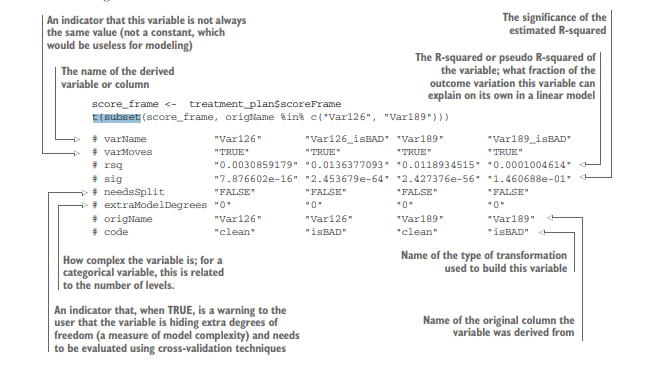

> In our example, Var126 produces two new or derived variables: `Var126` (a cleaned-up version of the original `Var126` that has no NA/missing values), and `Var116_isBAD` (an indicator variable that indicates which rows of Var126 originally held missing or bad values).

> The `rsq` column records the pseudo R-squared of the given variable, which is an indication of how informative the variable would be if treated as a single-variable model for the outcome. The `sig` column is an estimate of the significance of this
pseudo R-squared. Notice that `var126_isBAD` is more informative than the cleaned up original variable `var126`. This indicates we should consider including var126_isBAD in our model, even if we decide not to include the cleaned-up version of var126 itself!

In [26]:
t(subset(score_frame, origName == "Var218"))

,389,390,488,489
varName,Var218_catP,Var218_catB,Var218_lev_x_cJvF,Var218_lev_x_UYBR
varMoves,TRUE,TRUE,TRUE,TRUE
rsq,0.010955895,0.012709736,0.005295590,0.001970131
sig,4.836496e-52,4.394981e-60,4.902238e-26,1.218959e-10
needsSplit,TRUE,TRUE,FALSE,FALSE
extraModelDegrees,2,2,0,0
origName,Var218,Var218,Var218,Var218
code,catP,catB,lev,lev
default_threshold,0.006060606,0.006060606,0.001470588,0.001470588
recommended,TRUE,TRUE,TRUE,TRUE


In [28]:
#comparing impact variables (catB) with the original for Var218

comparison <- data.frame(original218 = dTrain$Var218,
                        impact218 = dTrain_treated$Var218_catB)

head(comparison)

original218,impact218
cJvF,-0.2180735
NA,1.5155125
UYBR,0.1221393
UYBR,0.1221393
UYBR,0.1221393
UYBR,0.1221393


> Var218 also has some missing values, but the missingness only occurs 1.5% of the time. If missingness had been more informative, then vtreat would have also created a Var218_lev_x_NA indicator, as well.

In [30]:
#convert NA values to a new level or 'safe string' _invalid_
treatment_plan_2 <- design_missingness_treatment(dTrain, varlist=vars)
dtrain_2 <- prepare(treatment_plan_2, dTrain)
head(dtrain_2$Var218)

[1] "cJvF"      "_invalid_" "UYBR"      "UYBR"      "UYBR"      "UYBR"

In [31]:
# fits the one-variable logistic regression model
model <- glm(churn == 1 ~ Var218,
            data = dtrain_2,
            family = "binomial")

# Makes prediction on the data
pred <- predict(model,
               newdata = dtrain_2,
               type = "response")

# calculates the global probability of churn
(prevalence <- mean(dTrain$churn == 1))

# A function to calculate the logit, or log-odds of a probability
logit <- function(p){
    log(p/(1-p))
}

comparison$glm218 <- logit(pred) - logit(prevalence)
head(comparison)

[1] 0.07347764

original218,impact218,glm218
cJvF,-0.2180735,-0.2180735
NA,1.5155125,1.5155121
UYBR,0.1221393,0.1221392
UYBR,0.1221393,0.1221392
UYBR,0.1221393,0.1221392
UYBR,0.1221393,0.1221392
